<a href="https://colab.research.google.com/github/Mateo289/Signal_theory/blob/main/Modelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

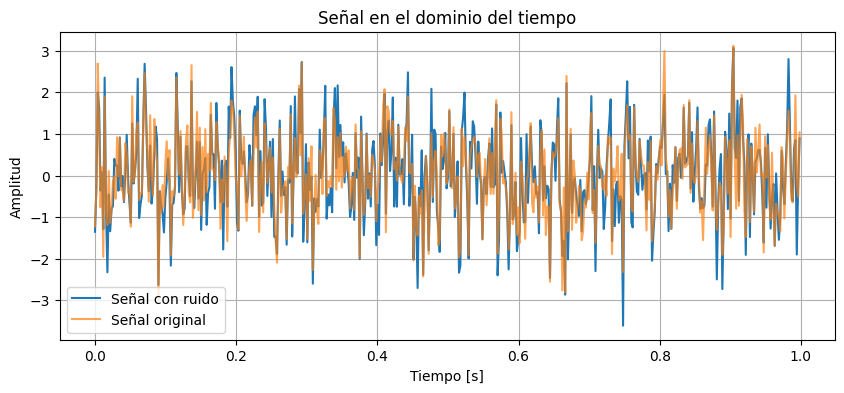

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.0970 - mae: 0.9233 - val_loss: 3.2550 - val_mae: 0.8048 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.0806 - mae: 0.8053 - val_loss: 2.5847 - val_mae: 0.7968 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4287 - mae: 0.7910 - val_loss: 2.0625 - val_mae: 0.7955 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9313 - mae: 0.7868 - val_loss: 1.6906 - val_mae: 0.7950 - learning_rate: 0.0010
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5853 - mae: 0.7827 - val_loss: 1.4433 - val_mae: 0.7947 - learning_rate: 0.0010
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3549 - mae: 0.7808 - val_loss: 1.2867 - val_mae: 0.7945 - learning_rate: 0.0010
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2188 - mae: 0.7792 - val_loss: 1.1906 - val_mae: 0.7945 - learning_rate: 0.0010
Epoch 8/50
25/25 ━━━━━━━━━━━━━

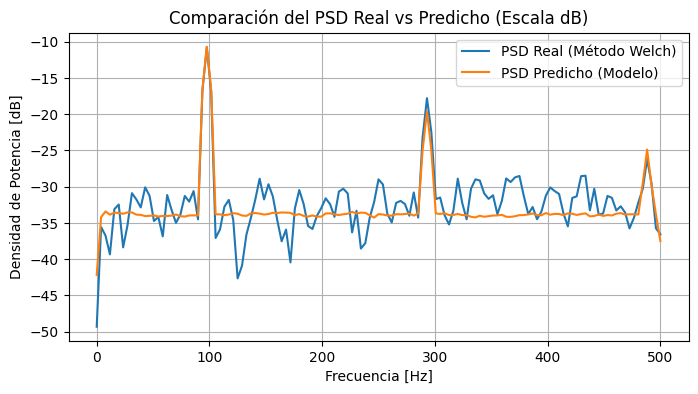

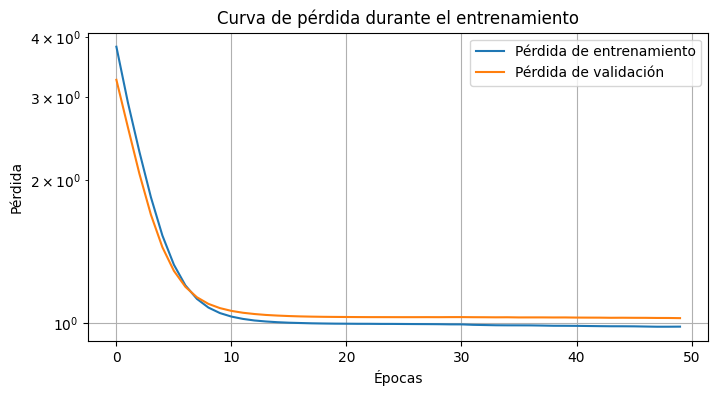

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.signal import welch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Configuración global
fs = 1000  # Frecuencia de muestreo
T = 1  # Duración de la señal en segundos
t = np.linspace(0, T, 512, endpoint=False)  # 512 muestras


# Clase para generación y preprocesamiento de datos
class DataGenerator:
    def __init__(self, num_samples=100):
        self.num_samples = num_samples

    def generate_signals(self):
        X, Y = [], []
        for _ in range(self.num_samples):
            # Generar señal original
            w0 = 2 * np.pi * 50  # Frecuencia base (50 Hz)
            x_original = (np.cos(w0 * t) - (1 / 3) * np.sin(3 * w0 * t) + (1 / 5) * np.cos(5 * w0 * t))

            # Añadir ruido
            ruido = np.random.normal(0, 0.5, t.shape)
            x_con_ruido = x_original + ruido

            # Calcular PSD
            f, psd = welch(x_con_ruido, fs, nperseg=256)
            psd_db = 10 * np.log10(psd)  # Convertir a dB

            X.append(x_con_ruido)
            Y.append(psd_db)

        return np.array(X), np.array(Y)

    @staticmethod
    def normalize_data(X, scaler=None):
        if scaler is None:
            scaler = StandardScaler()
        X_normalized = scaler.fit_transform(X)
        return X_normalized, scaler

    @staticmethod
    def normalize_labels(Y, scaler=None):
        if scaler is None:
            scaler = StandardScaler()
        Y_normalized = scaler.fit_transform(Y)
        return Y_normalized, scaler

    @staticmethod
    def split_data(X, Y, test_size=0.2, random_state=42):
        return train_test_split(X, Y, test_size=test_size, random_state=random_state)

    @staticmethod
    def visualize_signal(t, x_original, x_con_ruido):
        plt.figure(figsize=(10, 4))
        plt.plot(t, x_con_ruido, label="Señal con ruido")
        plt.plot(t, x_original, label="Señal original", alpha=0.7)
        plt.legend()
        plt.title("Señal en el dominio del tiempo")
        plt.xlabel("Tiempo [s]")
        plt.ylabel("Amplitud")
        plt.grid()
        plt.show()


# Clase para construir y entrenar el modelo
class PSDPredictor:
    def __init__(self, input_shape, n_frequencies):
        self.model = self.build_model(input_shape, n_frequencies)

    @staticmethod
    def build_model(input_shape, n_frequencies):
        model = Sequential([
            Flatten(input_shape=input_shape),
            Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
            Dropout(0.3),  # Regularización
            Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
            Dropout(0.3),  # Regularización
            Dense(n_frequencies, activation='linear')
        ])
        return model

    def compile_model(self, optimizer=None, loss='mse', metrics=['mae']):
        if optimizer is None:
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Tasa de aprendizaje inicial ajustada
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def train_model(self, X_train, Y_train, X_test, Y_test, epochs=50, batch_size=32):
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)
        return self.model.fit(
            X_train, Y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_test, Y_test),
            callbacks=[reduce_lr],
            verbose=1
        )

    def predict(self, X_test):
        return self.model.predict(X_test)

    @staticmethod
    def visualize_results(f, Y_test, Y_pred, scaler):
        Y_test_inv = scaler.inverse_transform(Y_test)
        Y_pred_inv = scaler.inverse_transform(Y_pred)
        plt.figure(figsize=(8, 4))
        plt.plot(f, Y_test_inv[0], label="PSD Real (Método Welch)")
        plt.plot(f, Y_pred_inv[0], label="PSD Predicho (Modelo)")
        plt.title("Comparación del PSD Real vs Predicho (Escala dB)")
        plt.xlabel("Frecuencia [Hz]")
        plt.ylabel("Densidad de Potencia [dB]")
        plt.legend()
        plt.grid()
        plt.show()

    @staticmethod
    def visualize_loss(history):
        plt.figure(figsize=(8, 4))
        plt.plot(history.history['loss'], label="Pérdida de entrenamiento")
        plt.plot(history.history['val_loss'], label="Pérdida de validación")
        plt.title("Curva de pérdida durante el entrenamiento")
        plt.xlabel("Épocas")
        plt.ylabel("Pérdida")
        plt.yscale("log")  # Escala logarítmica para mostrar comportamiento suave
        plt.legend()
        plt.grid()
        plt.show()


# Función principal para coordinar el flujo de trabajo
def main():
    # Generación de datos
    data_gen = DataGenerator(num_samples=1000)  # Más muestras para mejorar la generalización
    X, Y = data_gen.generate_signals()

    # Normalización de los datos
    X, x_scaler = data_gen.normalize_data(X)
    Y, y_scaler = data_gen.normalize_labels(Y)

    # División de datos
    X_train, X_test, Y_train, Y_test = data_gen.split_data(X, Y)

    # Visualización de una señal de ejemplo
    data_gen.visualize_signal(t, X[0], X[0] + np.random.normal(0, 0.5, t.shape))

    # Obtener el número de frecuencias
    n_frequencies = Y_train.shape[1]

    # Construcción y entrenamiento del modelo
    psd_predictor = PSDPredictor(input_shape=(512,), n_frequencies=n_frequencies)
    psd_predictor.compile_model()
    history = psd_predictor.train_model(X_train, Y_train, X_test, Y_test)

    # Evaluación y predicción
    Y_pred = psd_predictor.predict(X_test)

    # Visualización de resultados
    psd_predictor.visualize_results(np.linspace(0, fs / 2, len(Y_test[0])), Y_test, Y_pred, y_scaler)

    # Visualización de la curva de pérdida
    psd_predictor.visualize_loss(history)


# Ejecutar el flujo principal
if __name__ == "__main__":
    main()
